In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import keras
from models import model_v1, model_v2

2024-02-27 12:58:55.859393: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-27 12:58:56.103932: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 12:58:56.103979: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 12:58:56.143170: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-27 12:58:56.225504: I tensorflow/core/platform/cpu_feature_guar

In [6]:
# dataset
from pathlib import Path
from data_generator import DataGenerator

# training set data generator
root = "/home/ji/Dropbox/Robotics/CMSC733/Project1"
train_path = Path(root) / "Phase2" / "Data" / "Train"
train_gen = DataGenerator(train_path,mode="supervised")

# validation set
val_path = Path(root) / "Phase2" / "Data" / "Val"
val_gen = DataGenerator(val_path,mode="supervised")

# tensorflow dataset
im_shape = (train_gen.crop_size,train_gen.crop_size,3)
output_signature = ((tf.TensorSpec(shape=im_shape,dtype=tf.float32),
                     tf.TensorSpec(shape=im_shape,dtype=tf.float32)),
                     tf.TensorSpec(shape = (8,),dtype=tf.float32),
                    )
train_ds = tf.data.Dataset.from_generator(train_gen,
                                          output_signature=output_signature)
val_ds = tf.data.Dataset.from_generator(val_gen,
                                          output_signature=output_signature)

def config_ds(ds):
    AUTOTUNE = tf.data.AUTOTUNE
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    ds = ds.batch(8)
    return ds

train_ds = config_ds(train_ds)
val_ds = config_ds(val_ds)

# loss function
def custom_loss(y_true, y_pred):
    return 0.5*tf.reduce_mean(tf.square(y_true-y_pred))

def metric_abs(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true-y_pred))

In [16]:
# model version 2
model = model_v2(verbose=True)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=custom_loss, metrics=[metric_abs])

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_18 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 model_10 (Functional)       (None, 32, 32, 256)          2325568   ['input_17[0][0]',            
                                                                     'input_18[0][0]']            
                                                                                                  
 concatenate_5 (Concatenate  (None, 32, 32, 512)          0         ['model_10[0][0]',     

In [17]:
steps_per_epoch = 150

# reduce learning rate on plateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                                factor=0.2,
                                                patience=5,
                                                min_lr=1e-6,
                                                verbose=1,
                                                cooldown=5)

# save check points
checkpoint_filepath = './checkpoint_mdl_v2_rho32'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='loss',
    mode='min',
    save_freq = steps_per_epoch*10
    )

history = model.fit(train_ds,validation_data=val_ds,
                    validation_steps=30,
                    validation_freq=1,
                    epochs=150,verbose=True,
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[reduce_lr,checkpoint_callback])

Epoch 1/150
150/150 [==============================] - 21s 81ms/step - loss: 46.6871 - metric_abs: 8.3230 - val_loss: 47.5480 - val_metric_abs: 8.2945 - lr: 0.0010
Epoch 2/150
150/150 [==============================] - 12s 78ms/step - loss: 44.4038 - metric_abs: 8.0763 - val_loss: 59.5937 - val_metric_abs: 8.9837 - lr: 0.0010
Epoch 3/150
150/150 [==============================] - 12s 78ms/step - loss: 41.3183 - metric_abs: 7.7270 - val_loss: 76.9497 - val_metric_abs: 9.9848 - lr: 0.0010
Epoch 4/150
150/150 [==============================] - 12s 77ms/step - loss: 40.1688 - metric_abs: 7.5797 - val_loss: 59.3924 - val_metric_abs: 8.6785 - lr: 0.0010
Epoch 5/150
150/150 [==============================] - 11s 74ms/step - loss: 38.5611 - metric_abs: 7.4037 - val_loss: 57.8413 - val_metric_abs: 8.6093 - lr: 0.0010
Epoch 6/150
150/150 [==============================] - 11s 73ms/step - loss: 38.2261 - metric_abs: 7.3306 - val_loss: 40.6918 - val_metric_abs: 7.3896 - lr: 0.0010
Epoch 7/150
150/

INFO:tensorflow:Assets written to: ./checkpoint_mdl_v2/assets


150/150 [==============================] - 16s 108ms/step - loss: 27.5601 - metric_abs: 6.0038 - val_loss: 24.8537 - val_metric_abs: 5.6964 - lr: 0.0010
Epoch 11/150
150/150 [==============================] - 10s 70ms/step - loss: 24.9390 - metric_abs: 5.6257 - val_loss: 24.8723 - val_metric_abs: 5.6824 - lr: 0.0010
Epoch 12/150
150/150 [==============================] - 11s 73ms/step - loss: 23.8573 - metric_abs: 5.4967 - val_loss: 29.1002 - val_metric_abs: 5.9719 - lr: 0.0010
Epoch 13/150
150/150 [==============================] - 11s 75ms/step - loss: 23.1981 - metric_abs: 5.4167 - val_loss: 21.4288 - val_metric_abs: 5.2485 - lr: 0.0010
Epoch 14/150
150/150 [==============================] - 11s 74ms/step - loss: 22.8445 - metric_abs: 5.3810 - val_loss: 22.1488 - val_metric_abs: 5.1631 - lr: 0.0010
Epoch 15/150
150/150 [==============================] - 11s 73ms/step - loss: 21.8681 - metric_abs: 5.2486 - val_loss: 17.8250 - val_metric_abs: 4.6315 - lr: 0.0010
Epoch 16/150
150/150 [

INFO:tensorflow:Assets written to: ./checkpoint_mdl_v2/assets


150/150 [==============================] - 17s 111ms/step - loss: 18.7253 - metric_abs: 4.7940 - val_loss: 14.8408 - val_metric_abs: 4.2137 - lr: 0.0010
Epoch 21/150
150/150 [==============================] - 10s 68ms/step - loss: 18.1632 - metric_abs: 4.7267 - val_loss: 13.0907 - val_metric_abs: 3.9491 - lr: 0.0010
Epoch 22/150
150/150 [==============================] - 11s 72ms/step - loss: 18.2170 - metric_abs: 4.7115 - val_loss: 16.7316 - val_metric_abs: 4.4514 - lr: 0.0010
Epoch 23/150
150/150 [==============================] - 11s 72ms/step - loss: 18.5985 - metric_abs: 4.7708 - val_loss: 18.5325 - val_metric_abs: 4.7122 - lr: 0.0010
Epoch 24/150
150/150 [==============================] - 11s 73ms/step - loss: 17.8303 - metric_abs: 4.6827 - val_loss: 14.2997 - val_metric_abs: 4.0966 - lr: 0.0010
Epoch 25/150
150/150 [==============================] - 11s 72ms/step - loss: 17.6648 - metric_abs: 4.6429 - val_loss: 15.1034 - val_metric_abs: 4.2181 - lr: 0.0010
Epoch 26/150
150/150 [

INFO:tensorflow:Assets written to: ./checkpoint_mdl_v2/assets


150/150 [==============================] - 18s 119ms/step - loss: 15.8332 - metric_abs: 4.4023 - val_loss: 13.2882 - val_metric_abs: 3.9624 - lr: 0.0010
Epoch 31/150
150/150 [==============================] - 10s 68ms/step - loss: 16.3733 - metric_abs: 4.4689 - val_loss: 12.1230 - val_metric_abs: 3.8138 - lr: 0.0010
Epoch 32/150
150/150 [==============================] - 11s 76ms/step - loss: 16.1377 - metric_abs: 4.4252 - val_loss: 11.5989 - val_metric_abs: 3.6895 - lr: 0.0010
Epoch 33/150
150/150 [==============================] - 11s 76ms/step - loss: 16.1706 - metric_abs: 4.4192 - val_loss: 12.2762 - val_metric_abs: 3.7904 - lr: 0.0010
Epoch 34/150
150/150 [==============================] - 11s 76ms/step - loss: 16.0284 - metric_abs: 4.3881 - val_loss: 14.6525 - val_metric_abs: 4.1582 - lr: 0.0010
Epoch 35/150
150/150 [==============================] - ETA: 0s - loss: 16.3431 - metric_abs: 4.4270
Epoch 35: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
150/150 

INFO:tensorflow:Assets written to: ./checkpoint_mdl_v2/assets


150/150 [==============================] - 18s 120ms/step - loss: 13.0300 - metric_abs: 3.9667 - val_loss: 7.2153 - val_metric_abs: 2.8327 - lr: 2.0000e-04
Epoch 41/150
150/150 [==============================] - 10s 66ms/step - loss: 12.7089 - metric_abs: 3.9176 - val_loss: 7.6196 - val_metric_abs: 2.9997 - lr: 2.0000e-04
Epoch 42/150
150/150 [==============================] - 11s 73ms/step - loss: 12.9395 - metric_abs: 3.9503 - val_loss: 6.8730 - val_metric_abs: 2.7867 - lr: 2.0000e-04
Epoch 43/150
150/150 [==============================] - 11s 74ms/step - loss: 13.2932 - metric_abs: 3.9811 - val_loss: 6.6579 - val_metric_abs: 2.7553 - lr: 2.0000e-04
Epoch 44/150
150/150 [==============================] - 11s 73ms/step - loss: 13.0072 - metric_abs: 3.9726 - val_loss: 6.6897 - val_metric_abs: 2.7603 - lr: 2.0000e-04
Epoch 45/150
150/150 [==============================] - 11s 75ms/step - loss: 12.6812 - metric_abs: 3.9236 - val_loss: 6.4609 - val_metric_abs: 2.7101 - lr: 2.0000e-04
Epoc

INFO:tensorflow:Assets written to: ./checkpoint_mdl_v2/assets


150/150 [==============================] - 18s 119ms/step - loss: 12.6750 - metric_abs: 3.9289 - val_loss: 6.1606 - val_metric_abs: 2.6701 - lr: 2.0000e-04
Epoch 51/150
150/150 [==============================] - 10s 70ms/step - loss: 12.0400 - metric_abs: 3.8176 - val_loss: 5.7876 - val_metric_abs: 2.6098 - lr: 2.0000e-04
Epoch 52/150
150/150 [==============================] - 11s 74ms/step - loss: 12.5145 - metric_abs: 3.9086 - val_loss: 7.0936 - val_metric_abs: 2.8662 - lr: 2.0000e-04
Epoch 53/150
150/150 [==============================] - ETA: 0s - loss: 12.4239 - metric_abs: 3.8898
Epoch 53: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
150/150 [==============================] - 11s 73ms/step - loss: 12.4239 - metric_abs: 3.8898 - val_loss: 6.2027 - val_metric_abs: 2.6617 - lr: 2.0000e-04
Epoch 54/150
150/150 [==============================] - 11s 75ms/step - loss: 11.6433 - metric_abs: 3.7718 - val_loss: 6.2266 - val_metric_abs: 2.6183 - lr: 4.0000e-05
Epoch 

INFO:tensorflow:Assets written to: ./checkpoint_mdl_v2/assets


150/150 [==============================] - 16s 109ms/step - loss: 12.1387 - metric_abs: 3.8171 - val_loss: 5.0936 - val_metric_abs: 2.4351 - lr: 4.0000e-05
Epoch 61/150
150/150 [==============================] - 10s 66ms/step - loss: 11.4696 - metric_abs: 3.7122 - val_loss: 5.2901 - val_metric_abs: 2.4072 - lr: 4.0000e-05
Epoch 62/150
150/150 [==============================] - 12s 77ms/step - loss: 11.2193 - metric_abs: 3.6984 - val_loss: 5.3253 - val_metric_abs: 2.4034 - lr: 4.0000e-05
Epoch 63/150
150/150 [==============================] - 11s 76ms/step - loss: 11.2263 - metric_abs: 3.6914 - val_loss: 5.5082 - val_metric_abs: 2.4720 - lr: 4.0000e-05
Epoch 64/150
150/150 [==============================] - 11s 75ms/step - loss: 11.1615 - metric_abs: 3.6835 - val_loss: 5.4053 - val_metric_abs: 2.4707 - lr: 4.0000e-05
Epoch 65/150
150/150 [==============================] - 11s 76ms/step - loss: 11.4124 - metric_abs: 3.7314 - val_loss: 4.8102 - val_metric_abs: 2.3500 - lr: 4.0000e-05
Epoc

INFO:tensorflow:Assets written to: ./checkpoint_mdl_v2/assets


150/150 [==============================] - 17s 115ms/step - loss: 11.7259 - metric_abs: 3.7589 - val_loss: 5.7279 - val_metric_abs: 2.5257 - lr: 4.0000e-05
Epoch 71/150
150/150 [==============================] - 10s 66ms/step - loss: 11.4682 - metric_abs: 3.7186 - val_loss: 5.2869 - val_metric_abs: 2.4295 - lr: 4.0000e-05
Epoch 72/150
150/150 [==============================] - 11s 74ms/step - loss: 11.0023 - metric_abs: 3.6844 - val_loss: 5.2494 - val_metric_abs: 2.4356 - lr: 4.0000e-05
Epoch 73/150
150/150 [==============================] - 11s 74ms/step - loss: 11.0759 - metric_abs: 3.6759 - val_loss: 5.0900 - val_metric_abs: 2.4096 - lr: 4.0000e-05
Epoch 74/150
150/150 [==============================] - ETA: 0s - loss: 11.2465 - metric_abs: 3.6579
Epoch 74: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
150/150 [==============================] - 11s 74ms/step - loss: 11.2465 - metric_abs: 3.6579 - val_loss: 4.9925 - val_metric_abs: 2.3687 - lr: 4.0000e-05
Epoch 7

INFO:tensorflow:Assets written to: ./checkpoint_mdl_v2/assets


150/150 [==============================] - 17s 112ms/step - loss: 11.5284 - metric_abs: 3.7619 - val_loss: 4.9775 - val_metric_abs: 2.3184 - lr: 8.0000e-06
Epoch 81/150
150/150 [==============================] - 10s 65ms/step - loss: 11.6867 - metric_abs: 3.7504 - val_loss: 5.2682 - val_metric_abs: 2.4155 - lr: 8.0000e-06
Epoch 82/150
150/150 [==============================] - 11s 71ms/step - loss: 11.1192 - metric_abs: 3.6831 - val_loss: 4.7099 - val_metric_abs: 2.3066 - lr: 8.0000e-06
Epoch 83/150
150/150 [==============================] - ETA: 0s - loss: 11.1943 - metric_abs: 3.6806
Epoch 83: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
150/150 [==============================] - 11s 72ms/step - loss: 11.1943 - metric_abs: 3.6806 - val_loss: 4.7198 - val_metric_abs: 2.2626 - lr: 8.0000e-06
Epoch 84/150
150/150 [==============================] - 11s 72ms/step - loss: 11.1830 - metric_abs: 3.6968 - val_loss: 5.1569 - val_metric_abs: 2.4473 - lr: 1.6000e-06
Epoch 

INFO:tensorflow:Assets written to: ./checkpoint_mdl_v2/assets


150/150 [==============================] - 16s 110ms/step - loss: 11.0164 - metric_abs: 3.6780 - val_loss: 4.5125 - val_metric_abs: 2.2671 - lr: 1.6000e-06
Epoch 91/150
150/150 [==============================] - 10s 64ms/step - loss: 11.0809 - metric_abs: 3.6754 - val_loss: 4.4001 - val_metric_abs: 2.2600 - lr: 1.6000e-06
Epoch 92/150
150/150 [==============================] - 11s 72ms/step - loss: 10.6722 - metric_abs: 3.5843 - val_loss: 4.6438 - val_metric_abs: 2.3141 - lr: 1.6000e-06
Epoch 93/150
150/150 [==============================] - 11s 72ms/step - loss: 10.8132 - metric_abs: 3.6204 - val_loss: 5.0234 - val_metric_abs: 2.3460 - lr: 1.6000e-06
Epoch 94/150
150/150 [==============================] - 11s 72ms/step - loss: 11.3933 - metric_abs: 3.7269 - val_loss: 5.5667 - val_metric_abs: 2.5100 - lr: 1.6000e-06
Epoch 95/150
150/150 [==============================] - 11s 73ms/step - loss: 11.4043 - metric_abs: 3.7284 - val_loss: 5.4438 - val_metric_abs: 2.4653 - lr: 1.6000e-06
Epoc

INFO:tensorflow:Assets written to: ./checkpoint_mdl_v2/assets


150/150 [==============================] - 17s 111ms/step - loss: 11.1588 - metric_abs: 3.6897 - val_loss: 5.2544 - val_metric_abs: 2.4182 - lr: 1.0000e-06
Epoch 101/150
150/150 [==============================] - 10s 65ms/step - loss: 10.9536 - metric_abs: 3.6509 - val_loss: 4.7979 - val_metric_abs: 2.3139 - lr: 1.0000e-06
Epoch 102/150
150/150 [==============================] - 11s 72ms/step - loss: 11.1424 - metric_abs: 3.6691 - val_loss: 5.1054 - val_metric_abs: 2.4232 - lr: 1.0000e-06
Epoch 103/150
150/150 [==============================] - 11s 72ms/step - loss: 11.1052 - metric_abs: 3.6593 - val_loss: 5.0064 - val_metric_abs: 2.3712 - lr: 1.0000e-06
Epoch 104/150
150/150 [==============================] - 11s 72ms/step - loss: 10.9354 - metric_abs: 3.6480 - val_loss: 4.6128 - val_metric_abs: 2.2846 - lr: 1.0000e-06
Epoch 105/150
150/150 [==============================] - 11s 72ms/step - loss: 10.8946 - metric_abs: 3.6514 - val_loss: 4.5040 - val_metric_abs: 2.2632 - lr: 1.0000e-06

INFO:tensorflow:Assets written to: ./checkpoint_mdl_v2/assets


150/150 [==============================] - 16s 107ms/step - loss: 11.1036 - metric_abs: 3.6668 - val_loss: 5.2670 - val_metric_abs: 2.4753 - lr: 1.0000e-06
Epoch 111/150
150/150 [==============================] - 10s 65ms/step - loss: 11.1131 - metric_abs: 3.6850 - val_loss: 5.1852 - val_metric_abs: 2.4137 - lr: 1.0000e-06
Epoch 112/150
150/150 [==============================] - 11s 71ms/step - loss: 11.2849 - metric_abs: 3.7161 - val_loss: 5.3139 - val_metric_abs: 2.3709 - lr: 1.0000e-06
Epoch 113/150
150/150 [==============================] - 11s 72ms/step - loss: 11.4860 - metric_abs: 3.7697 - val_loss: 4.6576 - val_metric_abs: 2.3081 - lr: 1.0000e-06
Epoch 114/150
150/150 [==============================] - 11s 71ms/step - loss: 11.1813 - metric_abs: 3.6893 - val_loss: 4.7730 - val_metric_abs: 2.3318 - lr: 1.0000e-06
Epoch 115/150
150/150 [==============================] - 11s 72ms/step - loss: 11.1529 - metric_abs: 3.6906 - val_loss: 4.5770 - val_metric_abs: 2.3089 - lr: 1.0000e-06

INFO:tensorflow:Assets written to: ./checkpoint_mdl_v2/assets


150/150 [==============================] - 17s 111ms/step - loss: 10.9184 - metric_abs: 3.6370 - val_loss: 5.7483 - val_metric_abs: 2.4952 - lr: 1.0000e-06
Epoch 121/150
150/150 [==============================] - 10s 65ms/step - loss: 10.9579 - metric_abs: 3.6522 - val_loss: 5.5066 - val_metric_abs: 2.3861 - lr: 1.0000e-06
Epoch 122/150
150/150 [==============================] - 11s 71ms/step - loss: 11.0553 - metric_abs: 3.6456 - val_loss: 4.5837 - val_metric_abs: 2.2749 - lr: 1.0000e-06
Epoch 123/150
150/150 [==============================] - 11s 72ms/step - loss: 11.5644 - metric_abs: 3.7839 - val_loss: 5.9460 - val_metric_abs: 2.4945 - lr: 1.0000e-06
Epoch 124/150
150/150 [==============================] - 11s 72ms/step - loss: 10.7297 - metric_abs: 3.6231 - val_loss: 4.9068 - val_metric_abs: 2.3550 - lr: 1.0000e-06
Epoch 125/150
150/150 [==============================] - 11s 72ms/step - loss: 11.1988 - metric_abs: 3.6740 - val_loss: 4.9701 - val_metric_abs: 2.4111 - lr: 1.0000e-06

INFO:tensorflow:Assets written to: ./checkpoint_mdl_v2/assets


150/150 [==============================] - 17s 111ms/step - loss: 11.0834 - metric_abs: 3.6654 - val_loss: 5.4590 - val_metric_abs: 2.4416 - lr: 1.0000e-06
Epoch 131/150
150/150 [==============================] - 10s 64ms/step - loss: 10.9985 - metric_abs: 3.6651 - val_loss: 5.5394 - val_metric_abs: 2.4196 - lr: 1.0000e-06
Epoch 132/150
150/150 [==============================] - 11s 72ms/step - loss: 11.3438 - metric_abs: 3.6858 - val_loss: 4.5389 - val_metric_abs: 2.3069 - lr: 1.0000e-06
Epoch 133/150
150/150 [==============================] - 11s 72ms/step - loss: 11.3149 - metric_abs: 3.7335 - val_loss: 5.3787 - val_metric_abs: 2.4360 - lr: 1.0000e-06
Epoch 134/150
150/150 [==============================] - 11s 72ms/step - loss: 10.7031 - metric_abs: 3.6243 - val_loss: 5.3628 - val_metric_abs: 2.4304 - lr: 1.0000e-06
Epoch 135/150
150/150 [==============================] - 11s 72ms/step - loss: 11.3171 - metric_abs: 3.7048 - val_loss: 4.8861 - val_metric_abs: 2.3665 - lr: 1.0000e-06

INFO:tensorflow:Assets written to: ./checkpoint_mdl_v2/assets


150/150 [==============================] - 16s 110ms/step - loss: 11.3545 - metric_abs: 3.6951 - val_loss: 4.7156 - val_metric_abs: 2.3249 - lr: 1.0000e-06
Epoch 141/150
150/150 [==============================] - 10s 64ms/step - loss: 11.3482 - metric_abs: 3.7109 - val_loss: 4.7806 - val_metric_abs: 2.3232 - lr: 1.0000e-06
Epoch 142/150
150/150 [==============================] - 11s 72ms/step - loss: 10.9646 - metric_abs: 3.6370 - val_loss: 4.5035 - val_metric_abs: 2.2200 - lr: 1.0000e-06
Epoch 143/150
150/150 [==============================] - 11s 72ms/step - loss: 11.2424 - metric_abs: 3.6759 - val_loss: 4.9048 - val_metric_abs: 2.3147 - lr: 1.0000e-06
Epoch 144/150
150/150 [==============================] - 11s 71ms/step - loss: 11.5479 - metric_abs: 3.7297 - val_loss: 4.6533 - val_metric_abs: 2.3154 - lr: 1.0000e-06
Epoch 145/150
150/150 [==============================] - 11s 72ms/step - loss: 11.3954 - metric_abs: 3.6951 - val_loss: 5.0582 - val_metric_abs: 2.3273 - lr: 1.0000e-06

INFO:tensorflow:Assets written to: ./checkpoint_mdl_v2/assets


150/150 [==============================] - 17s 111ms/step - loss: 11.2231 - metric_abs: 3.6956 - val_loss: 4.8666 - val_metric_abs: 2.3656 - lr: 1.0000e-06


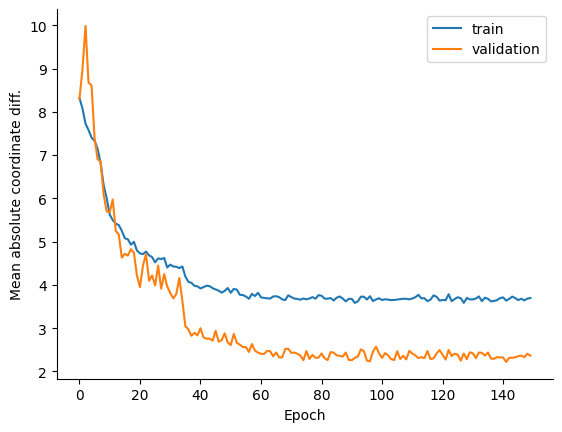

In [20]:
import matplotlib.pyplot as plt
plt.plot(history.history['metric_abs'])
plt.plot(history.history["val_metric_abs"])
plt.legend(["train","validation"])
plt.xlabel('Epoch')
plt.ylabel('Mean absolute coordinate diff.')
for pos in ['right', 'top']: 
    plt.gca().spines[pos].set_visible(False) 
plt.show()

In [ ]:
# load model
model_saved = keras.models.load_model('./checkpoint_mdl_v2',
                                   custom_objects={'custom_loss': custom_loss,
                                                   'metric_abs': metric_abs})